# Análisis de Series de Tiempo - TP Final

#### Alumna: María Carina Roldán

---

En este trabajo práctico se realiza un análisis de temperaturas de superficie terrestre (LST) a partir de información satelital.
Los datos a analizar corresponden a la temperatura de superficie de diferentes tipo de cobertura (pino y estepa)  de 3 pares de lotes localizados en la patagonia cordillerana argentina. Para este análisis se extrajeron datos de 5 años consecutivos (2020-2024).

El propósito del trabajo es:

- realizar un análisis exploratorio de los datos.
- analizar las series de tiempo del delta de temperatura entre diferentes tipos de cobertura.
- pronosticar el delta para fechas futuras usando 3 modelos diferentes.
- comparar resultados.


## 1. Lectura y preparación de los datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

`MODIS_Aqua_Terra.csv` contiene los datos crudos generados en Google Earth Engine.

Los datos provienen de dos productos MODIS que ya agregan las temperaturas de superficie terrestre (LST) cada 8 días.

Hay 4 datos para cada fecha y para cada tipo de cobertura (pino/estepa):
dos registros de LST diurna y dos de LST nocturna.

In [2]:
df_aquaterra = pd.read_csv("csv/MODIS_Aqua_Terra.csv",parse_dates=["fecha"])
df_aquaterra=df_aquaterra.dropna()
df_aquaterra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916 entries, 0 to 917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   system:index  916 non-null    object        
 1   LST_Day       916 non-null    float64       
 2   LST_Night     916 non-null    float64       
 3   especie       916 non-null    object        
 4   fecha         916 non-null    datetime64[ns]
 5   satelite      916 non-null    object        
 6   .geo          916 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 57.2+ KB


In [3]:
df_aquaterra

,system:index,LST_Day,LST_Night,especie,fecha,satelite,.geo
0,1_1_1_2020_01_01,33.942028,11.386103,pino,2020-01-01,Aqua,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_1_1_2020_01_09,29.756093,6.885422,pino,2020-01-09,Aqua,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,1_1_1_2020_01_17,37.546916,12.313883,pino,2020-01-17,Aqua,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,1_1_1_2020_01_25,31.540726,8.237091,pino,2020-01-25,Aqua,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,1_1_1_2020_02_02,30.085814,7.463590,pino,2020-02-02,Aqua,"{""type"":""MultiPoint"",""coordinates"":[]}"
...,...,...,...,...,...,...,...
913,2_2024_11_24,24.426813,4.805732,estepa,2024-11-24,Terra,"{""type"":""MultiPoint"",""coordinates"":[]}"
914,2_2024_12_02,27.793969,4.212328,estepa,2024-12-02,Terra,"{""type"":""MultiPoint"",""coordinates"":[]}"
915,2_2024_12_10,30.499777,9.454714,estepa,2024-12-10,Terra,"{""type"":""MultiPoint"",""coordinates"":[]}"
916,2_2024_12_18,28.830324,9.630623,estepa,2024-12-18,Terra,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [4]:
# agrupo los valores de Aqua y Terra para generar un df con 1 fila por fecha y especie
df = df_aquaterra.groupby(['fecha', 'especie'])[['LST_Day', 'LST_Night']].mean().reset_index()
df['LST'] = (df['LST_Day'] + df['LST_Night'])/2  # el promedio de las temperaturas
df['mes'] = df['fecha'].dt.month
df

,fecha,especie,LST_Day,LST_Night,LST,mes
0,2020-01-01,estepa,36.280639,11.242220,23.761430,1
1,2020-01-01,pino,30.976251,11.761687,21.368969,1
2,2020-01-09,estepa,33.107195,7.384291,20.245743,1
3,2020-01-09,pino,26.849177,7.588929,17.219053,1
4,2020-01-17,estepa,40.126597,12.101199,26.113898,1
...,...,...,...,...,...,...
455,2024-12-10,pino,28.121869,8.253108,18.187489,12
456,2024-12-18,estepa,33.443165,8.186683,20.814924,12
457,2024-12-18,pino,28.399993,8.271893,18.335943,12
458,2024-12-26,estepa,36.246517,12.394736,24.320627,12


In [5]:
# Para generar un df para temperaturas diurnas o otro para nocturas, creo un df temp
# con las especies como columnas y LST_Day y LST_Night como filas
df_temp = (
    df_aquaterra
    .melt(id_vars=['fecha', 'especie'], value_vars=['LST_Day', 'LST_Night'],
          var_name='dia_noche', value_name='valor')
    .pivot_table(index=['fecha', 'dia_noche'], columns='especie', values='valor', aggfunc='mean')
    .reset_index()
)
df_temp['mes'] = df_temp['fecha'].dt.month
df_temp['delta'] = df_temp['estepa'] - df_temp['pino']
df_temp.columns.name = None
df_temp

,fecha,dia_noche,estepa,pino,mes,delta
0,2020-01-01,LST_Day,36.280639,30.976251,1,5.304388
1,2020-01-01,LST_Night,11.242220,11.761687,1,-0.519467
2,2020-01-09,LST_Day,33.107195,26.849177,1,6.258017
3,2020-01-09,LST_Night,7.384291,7.588929,1,-0.204639
4,2020-01-17,LST_Day,40.126597,33.924788,1,6.201808
...,...,...,...,...,...,...
455,2024-12-10,LST_Night,8.124529,8.253108,12,-0.128579
456,2024-12-18,LST_Day,33.443165,28.399993,12,5.043172
457,2024-12-18,LST_Night,8.186683,8.271893,12,-0.085211
458,2024-12-26,LST_Day,36.246517,30.857098,12,5.389419


In [6]:
# Separo un df para el día ...
df_d = df_temp[df_temp['dia_noche'] == 'LST_Day']
df_d=df_d.drop(columns='dia_noche')
df_d

,fecha,estepa,pino,mes,delta
0,2020-01-01,36.280639,30.976251,1,5.304388
2,2020-01-09,33.107195,26.849177,1,6.258017
4,2020-01-17,40.126597,33.924788,1,6.201808
6,2020-01-25,34.904348,28.310403,1,6.593945
8,2020-02-02,34.400693,27.574299,2,6.826394
...,...,...,...,...,...
450,2024-11-24,26.526460,21.428076,11,5.098384
452,2024-12-02,29.914701,24.646389,12,5.268312
454,2024-12-10,33.468562,28.121869,12,5.346693
456,2024-12-18,33.443165,28.399993,12,5.043172


In [7]:
# y otro df para la noche ...
df_n = df_temp[df_temp['dia_noche'] == 'LST_Night']
df_n=df_n.drop(columns='dia_noche')
df_n

,fecha,estepa,pino,mes,delta
1,2020-01-01,11.242220,11.761687,1,-0.519467
3,2020-01-09,7.384291,7.588929,1,-0.204639
5,2020-01-17,12.101199,13.115697,1,-1.014498
7,2020-01-25,8.871062,9.221731,1,-0.350669
9,2020-02-02,8.121886,8.396090,2,-0.274203
...,...,...,...,...,...
451,2024-11-24,4.072646,4.045666,11,0.026980
453,2024-12-02,3.399297,3.033563,12,0.365734
455,2024-12-10,8.124529,8.253108,12,-0.128579
457,2024-12-18,8.186683,8.271893,12,-0.085211


#### Exportación

Guardo los datos (para un posterior análisis o para usarlos en otra Notebook).

In [8]:
df.to_csv('csv/ts.csv', index=False)
df_d.to_csv('csv/ts_d.csv', index=False)
df_n.to_csv('csv/ts_n.csv', index=False)

## 2. EDA

In [9]:
# colores para los gráficos
colores = {
    'estepa':   '#FF6347',  # Rojo anaranjado
    'pino':     '#2E8B57',  # Verde bosque
    'dia':      '#FFA726',  # Naranja suave
    'noche':    '#4169E1',  # Azul royal
    'datos':    '#E2725B',  # Terracota claro
    'trend':    '#2E8B57',  # Verde bosque
    'season':   '#4169E1',  # Azul royal
    'residuo':  '#9E9E9E',  # Gris medio
    'train':    '#9E9E9E',  # Gris medio
    'test':     '#2B2B2B',  # Gris oscuro
    'HW':       '#00FA9A',  # Verde menta
    'SARIMA':   '#6A5ACD',  # Lavanda
    'SARIMA_IC':'#C5B4E3',  # Lavanda claro
    'LSTM':     '#E57373'   # Rojo suave
    }

In [10]:
df.describe()

,fecha,LST_Day,LST_Night,LST,mes
count,460,460.000000,460.000000,460.000000,460.000000
mean,2022-06-29 19:12:00,18.527706,2.875682,10.701694,6.460870
min,2020-01-01 00:00:00,-2.119378,-8.680690,-5.374545,1.000000
25%,2021-03-30 00:00:00,6.859275,-1.459469,2.770561,3.000000
50%,2022-06-30 00:00:00,19.476074,3.107856,10.907822,6.500000
75%,2023-09-30 00:00:00,29.037910,7.491157,18.182614,9.000000
max,2024-12-26 00:00:00,42.626237,13.715312,27.445774,12.000000
std,NaN,12.167203,5.324880,8.590457,3.467338


In [11]:
df_d[['estepa', 'pino', 'delta']].describe()

,estepa,pino,delta
count,230.000000,230.000000,230.000000
mean,20.125681,16.929730,3.195950
std,12.887961,11.202645,1.929531
min,-2.119378,-1.991103,-2.065951
25%,7.424101,6.096644,1.478557
50%,21.381552,17.586683,3.305176
75%,32.175293,26.977300,4.740643
max,42.626237,38.302324,7.416961


In [12]:
df_n[['estepa', 'pino', 'delta']].describe()

,estepa,pino,delta
count,230.000000,230.000000,230.000000
mean,2.623011,3.128352,-0.505341
std,5.332321,5.317013,0.530696
min,-8.680690,-7.882568,-2.074271
25%,-1.841441,-0.965253,-0.836031
50%,2.941339,3.550666,-0.503181
75%,7.163452,7.688528,-0.155560
max,13.205328,13.715312,1.275455


### Exploración de temperaturas por especie y por momento del día

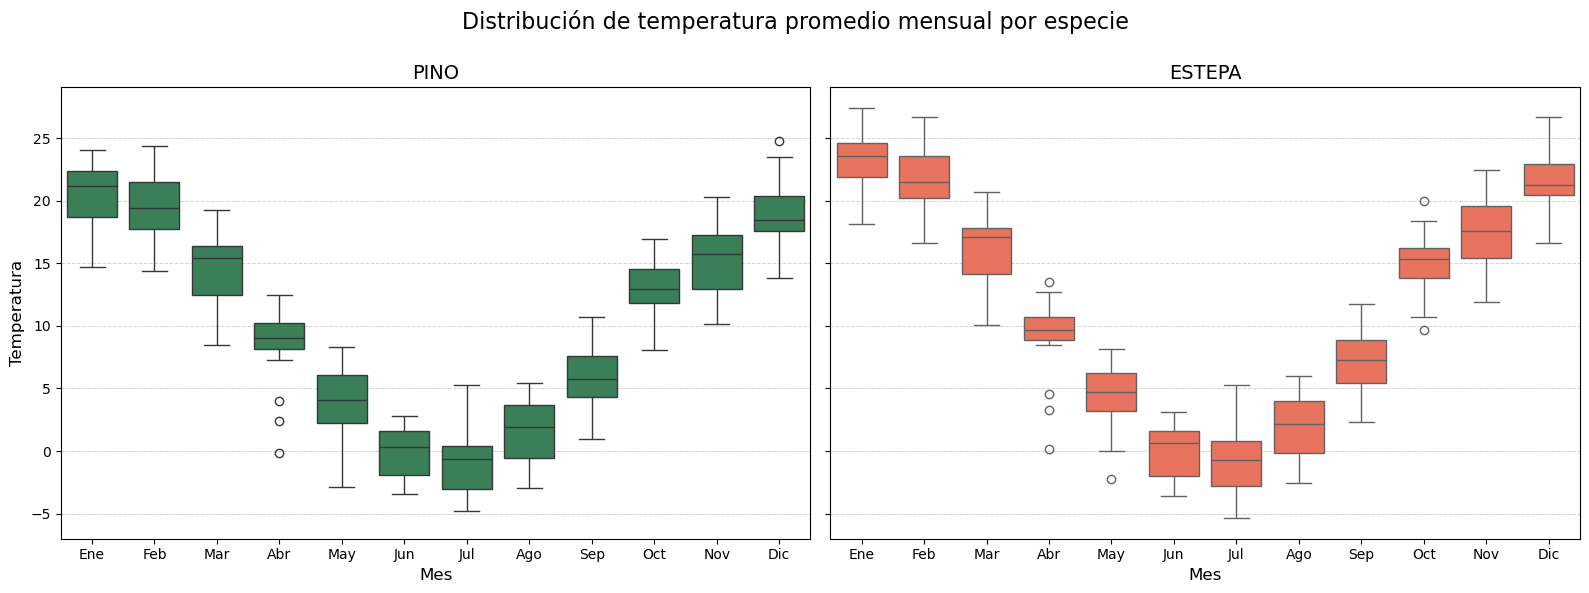

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribución de temperatura promedio mensual por especie', fontsize=16)

# Boxplot para temperaturas de pino
sns.boxplot(
    data=df[df['especie']=='pino'],
    x='mes',
    y='LST',
    ax=axes[0],
    color=colores['pino']
)
axes[0].set_title('PINO', fontsize=14)
axes[0].set_ylabel('Temperatura', fontsize=12)

# Boxplot para temperaturas de estepa
sns.boxplot(
    data=df[df['especie']=='estepa'],
    x='mes',
    y='LST',
    ax=axes[1],
    color=colores['estepa']
)
axes[1].set_title('ESTEPA', fontsize=14)
axes[1].set_ylabel('', fontsize=12)

# Ajustar etiquetas de los ejes X
for ax in axes:
    ax.set_xticks(range(0, 12))
    ax.set_xlabel('Mes', fontsize=12)
    ax.set_xticklabels([
        'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
    ], fontsize=10),
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7)

# Mostrar el gráfico
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

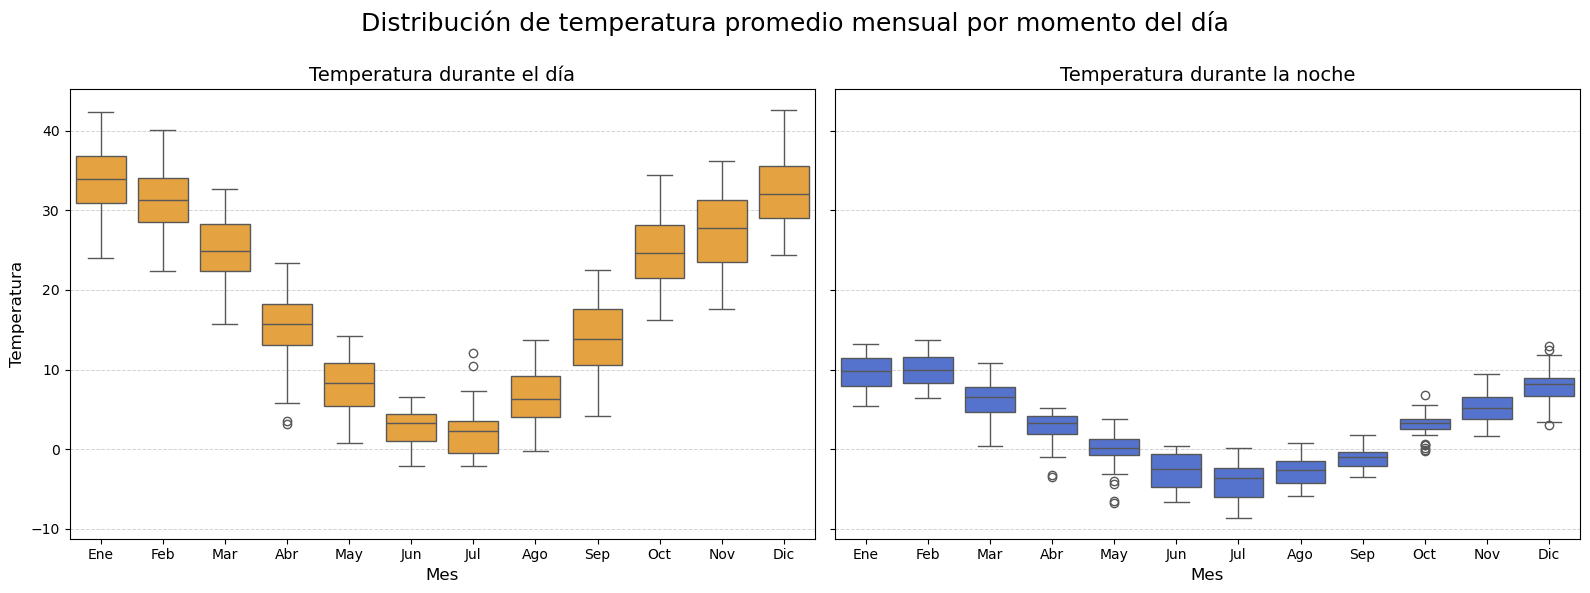

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribución de temperatura promedio mensual por momento del día', fontsize=18)

# Boxplot para valores de día
sns.boxplot(
    data=df,
    x='mes',
    y='LST_Day',
    ax=axes[0],
    color=colores['dia']
)
axes[0].set_title('Temperatura durante el día', fontsize=14)
axes[0].set_ylabel('Temperatura', fontsize=12)

# Boxplot para valores de noche
sns.boxplot(
    data=df,
    x='mes',
    y='LST_Night',
    ax=axes[1],
     color=colores['noche']
)
axes[1].set_title('Temperatura durante la noche', fontsize=14)
axes[1].set_ylabel('', fontsize=12)

# Ajustar etiquetas de los ejes X
for ax in axes:
    ax.set_xticks(range(0, 12))
    ax.set_xlabel('Mes', fontsize=12)
    ax.set_xticklabels([
        'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
    ], fontsize=10),
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7)

# Mostrar el gráfico
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Ajustar espacio para el título general
plt.show()

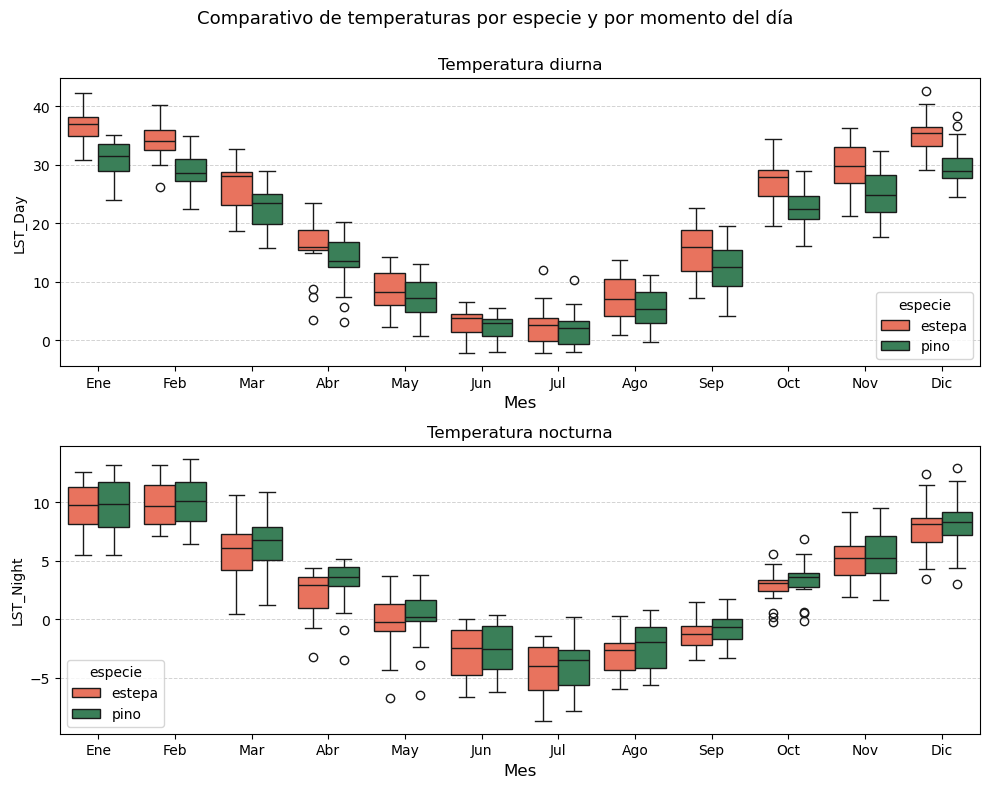

In [15]:
fig, axes = plt.subplots(2,1, figsize=(10, 8)) #, sharey=True)
fig.suptitle('Comparativo de temperaturas por especie y por momento del día', fontsize=13)

sns.boxplot(
    data=df,
    x='mes',
    y='LST_Day',
    hue='especie',
    palette=colores,
    ax=axes[0]
)
axes[0].set_title('Temperatura diurna', fontsize=12)

sns.boxplot(
    data=df,
    x='mes',
    y='LST_Night',
    hue='especie',
    palette=colores,
    ax=axes[1]
)
axes[1].set_title('Temperatura nocturna', fontsize=12)

for i in [0,1]:
    axes[i].set_xlabel('Mes', fontsize=12)
    axes[i].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    axes[i].set_xticks(ticks=range(0, 12), fontsize=10,
                       labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Deltas de temperatura diurna y nocturna

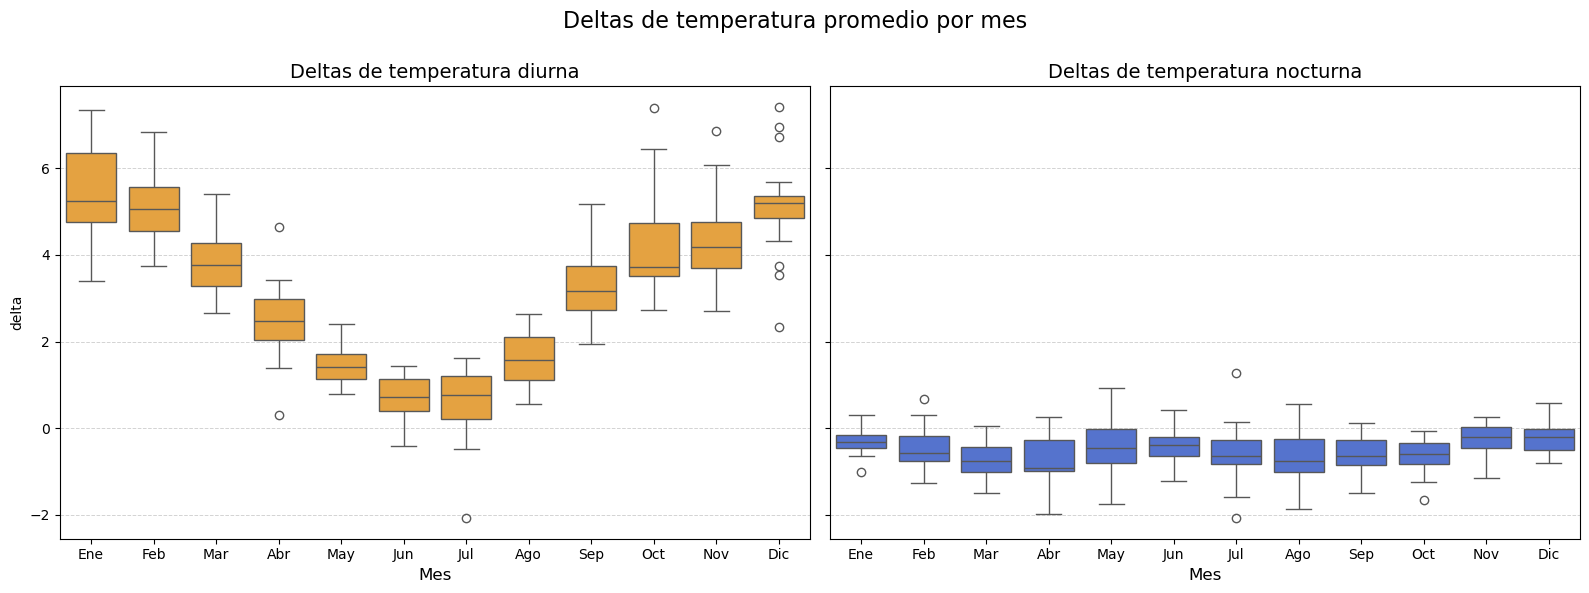

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Deltas de temperatura promedio por mes', fontsize=16)

sns.boxplot(
    data=df_d,
    x='mes',
    y='delta',
    color=colores['dia'],
    ax=axes[0]
)
axes[0].set_title('Deltas de temperatura diurna', fontsize=14)

sns.boxplot(
    data=df_n,
    x='mes',
    y='delta',
    color=colores['noche'],
    ax=axes[1]
)
axes[1].set_title('Deltas de temperatura nocturna', fontsize=14)

for i in [0,1]:
    axes[i].set_xlabel('Mes', fontsize=12)
    axes[i].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    axes[i].set_xticks(ticks=range(0, 12), fontsize=10,
                       labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

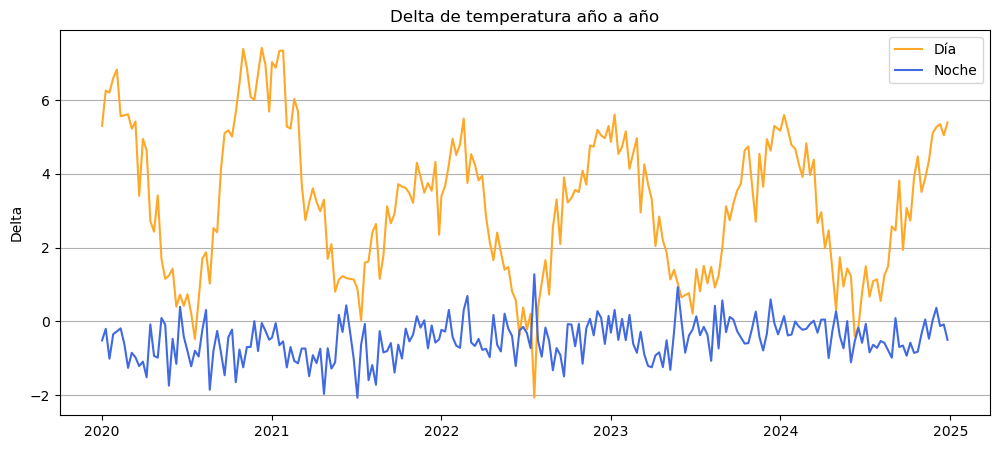

In [17]:
plt.figure(figsize=(12, 5))

plt.plot(df_d['fecha'], df_d['delta'], label='Día', color=colores['dia'])
plt.plot(df_n['fecha'], df_n['delta'], label='Noche', color=colores['noche'])
plt.title('Delta de temperatura año a año')
plt.ylabel('Delta')
plt.grid(axis='y')
plt.legend()
plt.show()

## 3. Análisis de series de tiempo

In [18]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

Tenemos tres dataframes con las siguientes series:
- df: toda la información de las LST de los 5 años, para pino y para estepa.
- df_d / df_n: las LST diurna y nocturna respectivamente. Cada df tiene las LST de pino y estepa junto con el delta de estas temperaturas = LST estepa - LST pino.

### Media móvil

Vamos a suavizar las series df_d y df_n mediante el cálculo de una media móvil de 4 semanas.

Con esto eliminamos el ruido de corto plazo, para hacer más visibles las tendencias o ciclos.

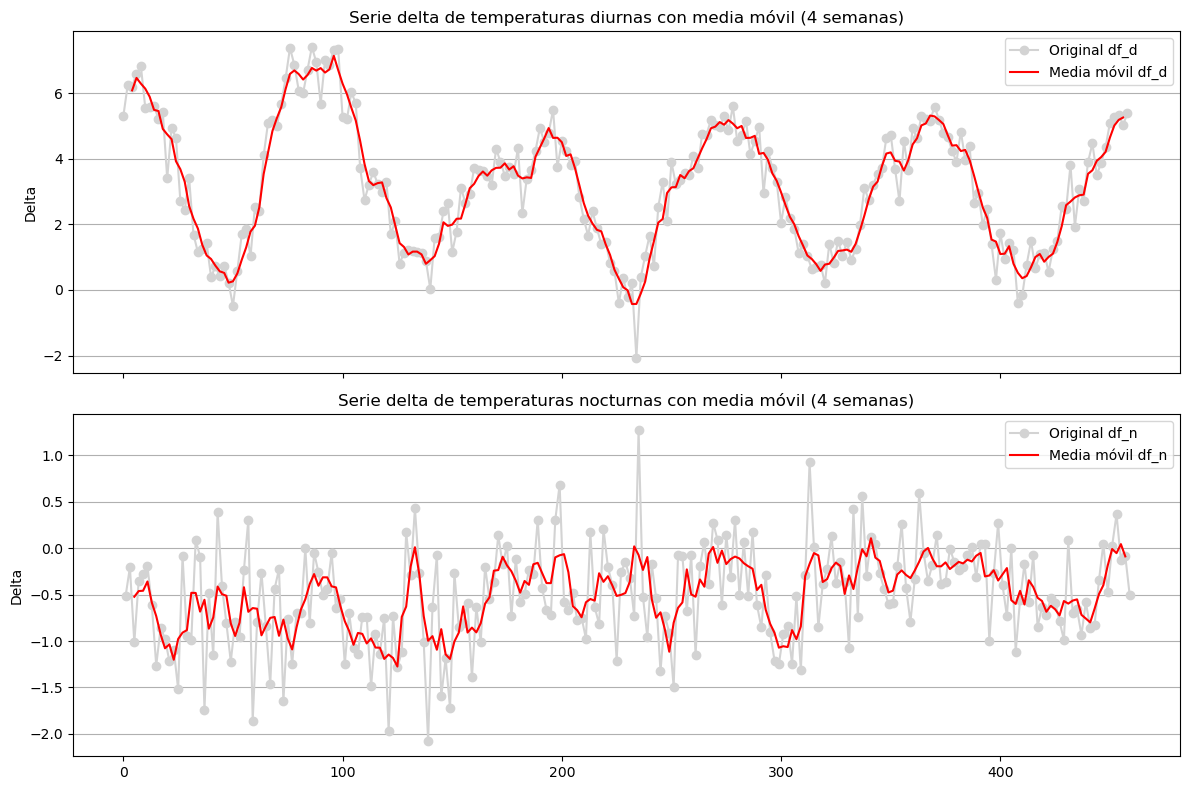

In [19]:
# Calcula media móvil de 4 semanas para ambas series
df_n['delta_medio'] = df_n['delta'].rolling(window=4, center=True).mean()
df_d['delta_medio'] = df_d['delta'].rolling(window=4, center=True).mean()

# Crear subplots
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# Delta día
axes[0].plot(df_d.index, df_d['delta'], label='Original df_d', marker='o', color='lightgray')
axes[0].plot(df_d.index, df_d['delta_medio'], label='Media móvil df_d', color='red')
axes[0].set_title("Serie delta de temperaturas diurnas con media móvil (4 semanas)")
axes[0].set_ylabel("Delta")
axes[0].grid(axis='y')
axes[0].legend()

# Delta noche
axes[1].plot(df_n.index, df_n['delta'], label='Original df_n', marker='o', color='lightgray')
axes[1].plot(df_n.index, df_n['delta_medio'], label='Media móvil df_n', color='red')
axes[1].set_title("Serie delta de temperaturas nocturnas con media móvil (4 semanas)")
axes[1].set_ylabel("Delta")
axes[1].grid(axis='y')
axes[1].legend()
plt.tight_layout()
plt.show()

### Seasonal decompose

Usamos Seasonal decompose para estimar tendencia y extraer estacionalidad y residuales.

El gráfico muestra:
- Datos
- Tendencia: cambios a largo plazo
- Estacionalidad: patrón repetitivo anual
- Residual: ruido o anomalías

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
def plot_decomposition(result, cual):
    # Crear figura personalizada
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

    # Graficar cada componente en su subplot
    axes[0].plot(result.observed, label='Delta', color=colores['datos'])
    axes[0].set_ylabel('Delta')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(result.trend, label='Tendencia', color=colores['trend'])
    axes[1].set_ylabel('Tendencia')
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(result.seasonal, label='Estacionalidad', color=colores['season'])
    axes[2].set_ylabel('Estacionalidad')
    axes[2].legend()
    axes[2].grid()

    axes[3].plot(result.resid, label='Residuo', color=colores['residuo'])
    axes[3].set_ylabel('Residuo')
    axes[3].legend()
    axes[3].grid()

    # Título general
    fig.suptitle(f"Descomposición estacional de deltas de temperatura {cual}", fontsize=16)
    plt.tight_layout()

    plt.show()

In [22]:
dfs = {
    'delta_dia': df_d,
    'delta_noche': df_n
}

prepared = {}  # series preparadas
decompositions = {}  # resultados

for name, data in dfs.items():
    temp_df = data[['fecha', 'delta']].set_index('fecha').sort_index()
    prepared[name] = temp_df
    decompositions[name] = seasonal_decompose(temp_df['delta'], model='additive', period=46)

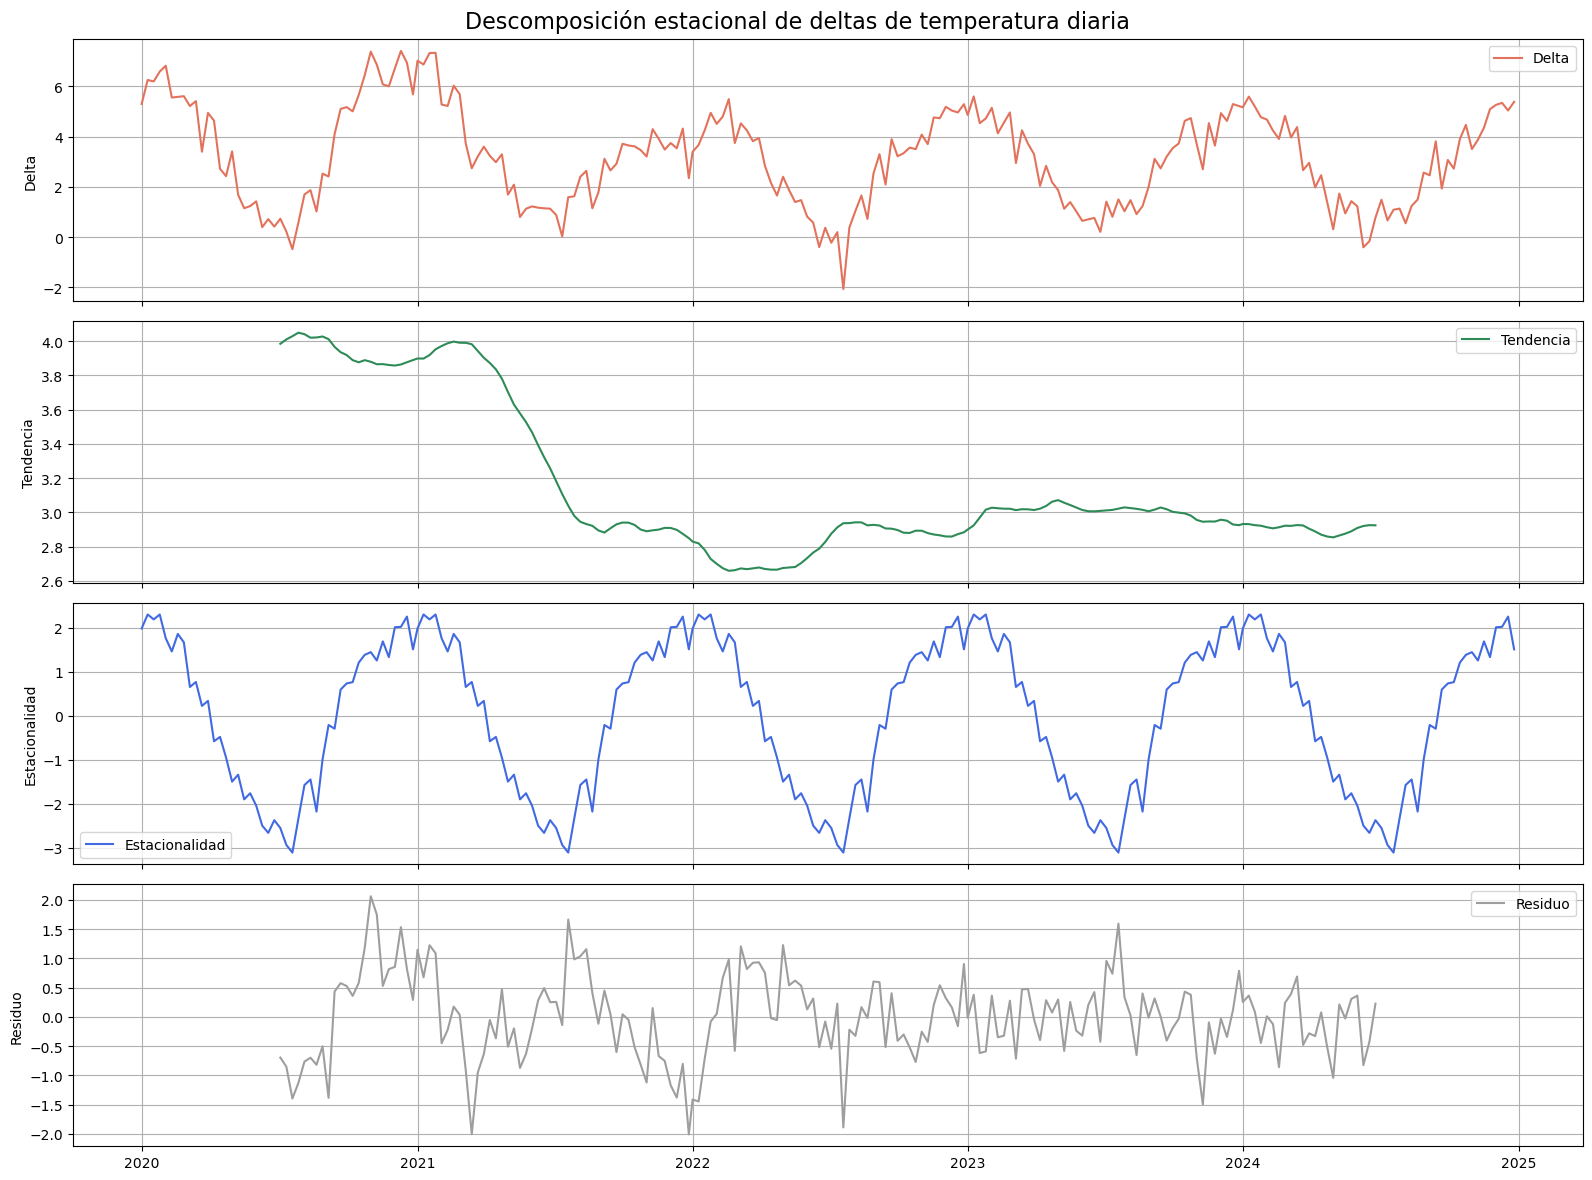

In [23]:
plot_decomposition(decompositions['delta_dia'], 'diaria')

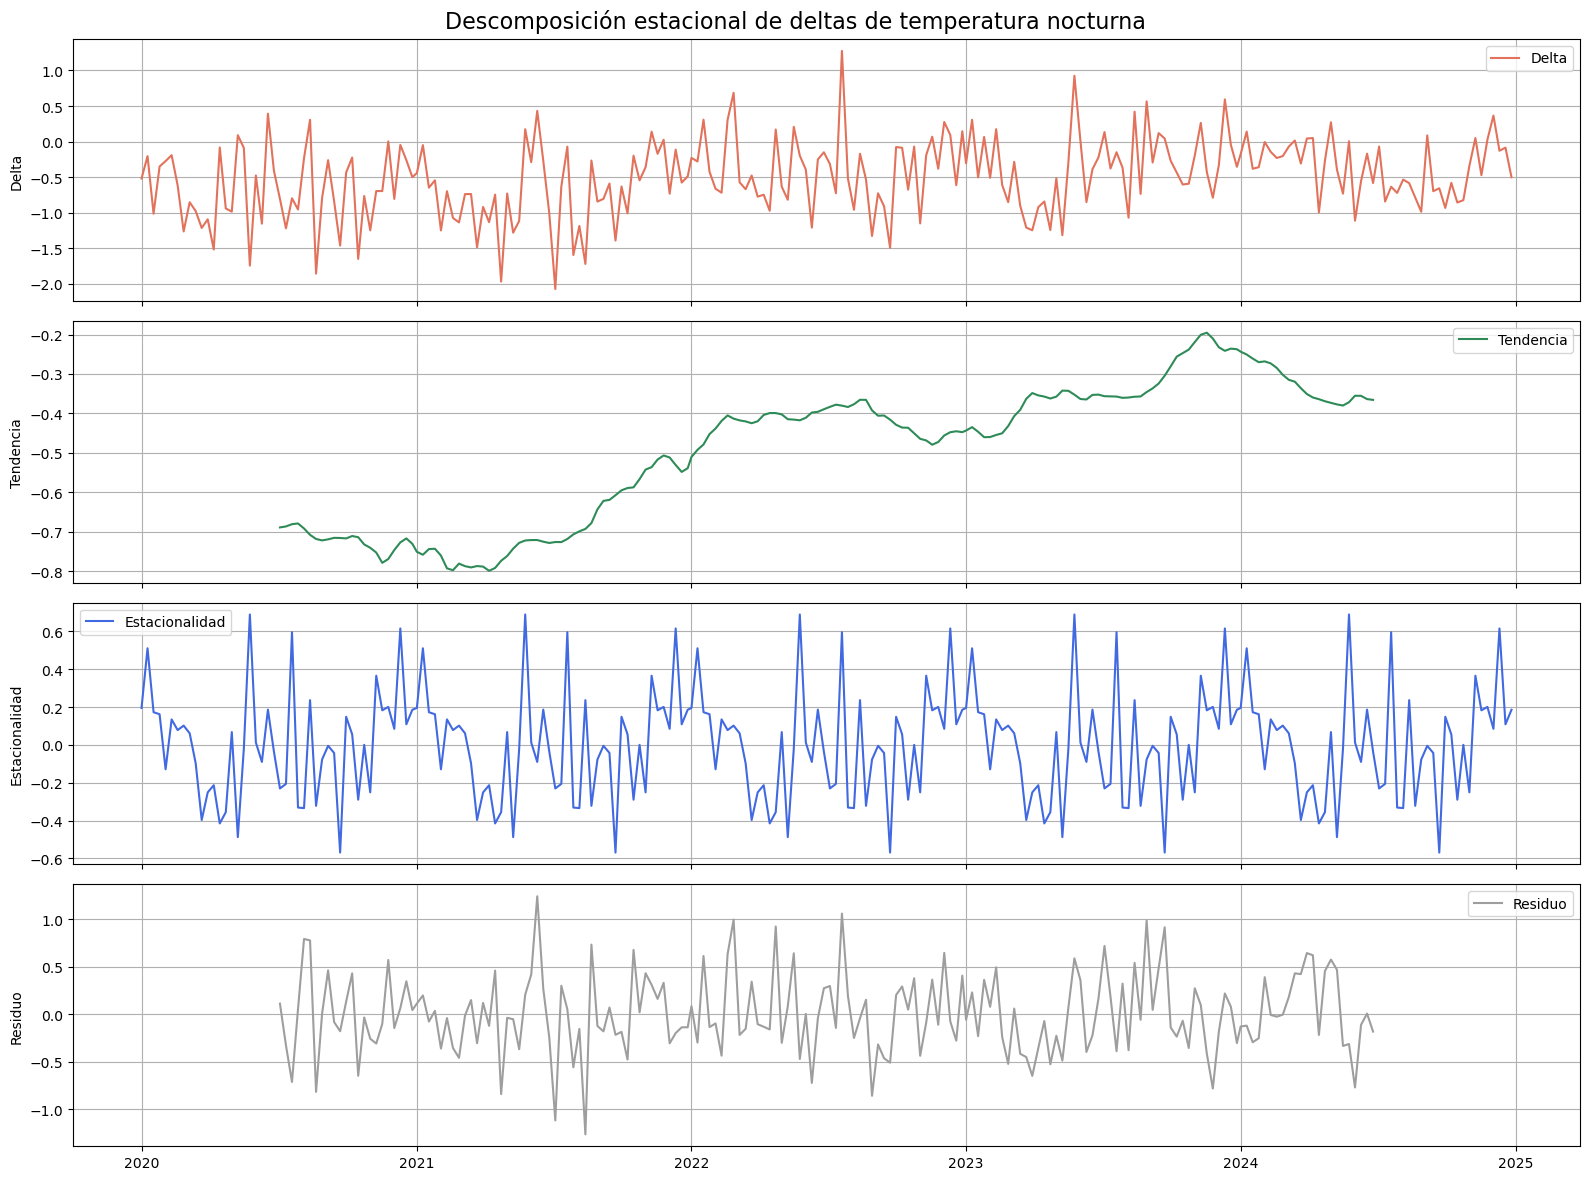

In [24]:
plot_decomposition(decompositions['delta_noche'], 'nocturna')

### Estacionaridad de la serie nocturna

Con la prueba de Dickey-Fuller Aumentada (ADF) vamos a ver si se puede confirmar la observación preliminar sobre la estacionaridad de esta serie.

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_n['delta'])
print(f"Serie no diferenciada - p-valor: {result[1]}")

serie_diff1 = df_n['delta'].diff().dropna()
result = adfuller(serie_diff1)
print(f"Serie diferenciada (orden 1) - p-valor: {result[1]:.4f}")

Serie no diferenciada - p-valor: 2.474718882449264e-05
Serie diferenciada (orden 1) - p-valor: 0.0000


En este caso, el p-valor inicial es 0.000024747 (muy por debajo del umbral `0.05`), por lo que se rechaza la hipótesis nula. Se concluye que la serie original es estacionaria, es decir, su comportamiento no depende del momento en el que se observe.

## 4. Modelos predictivos

Vamos a implementar y evaluar tres modelos que nos permitan predecir el **delta de temperatura diaria** entre superficies de pino y estepa:

- Holt-Winters (Exponential Smoothing)
- SARIMA (Seasonal ARIMA)
- LSTM

Vamos a usar 80 % de datos para entrenamiento y 20 % para test.

Para respetar la naturaleza temporal de los datos, se tomarán para entrenamiento ~ 4 años y para test el último año de datos.

La comparación de los resultados se hará en forma visual (interpretar gráficos de predicciones vs valores de test) y cuantitativa, mediante el cálculo y la comparación de las siguientes métricas:
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)


In [26]:
def guardar_estadisticas( modelo, mae_hw, mse_hw, rmse_hw):
    if modelo in df_resultados['Modelo'].values:
        df_resultados.loc[df_resultados['Modelo'] == modelo, [ 'MAE', 'MSE', 'RMSE']] = [mae_hw, mse_hw, rmse_hw]
    else:
        df_resultados.loc[len(df_resultados)] = [modelo, mae_hw, mse_hw, rmse_hw]

# Dataframe para guardar los resultados
df_resultados = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE'])

### Preparación de datos para entrenamiento

Se entrenarán modelos para dos series distintas:
- delta de temperaturas diarias (train_dia / test_dia)
- delta de temperaturas nocturnas (train_noche / test_noche)

In [27]:
df_serie = df_d[['fecha','delta']]
df_serie = df_serie.set_index('fecha')
df_serie.index = pd.to_datetime(df_serie.index)
df_serie.head()

,delta
fecha,
2020-01-01,5.304388
2020-01-09,6.258017
2020-01-17,6.201808
2020-01-25,6.593945
2020-02-02,6.826394


In [28]:
train_size = int(len(df_serie) * 0.8)  # 80% entrenamiento, 20% test
train_size

184

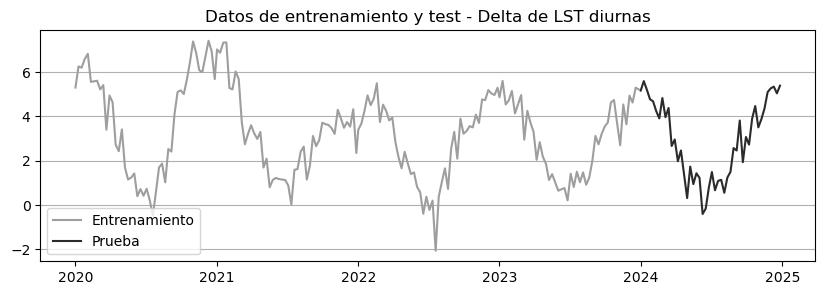

In [29]:
train = df_serie['delta'].iloc[:train_size]
test = df_serie['delta'].iloc[train_size:]

plt.figure(figsize=(10, 3))
plt.plot(train, label='Entrenamiento', color=colores['train'])
plt.plot(test, label='Prueba', color=colores['test'])
#plt.legend()
plt.legend(loc='lower left')

plt.grid(axis='y')
plt.title('Datos de entrenamiento y test - Delta de LST diurnas')
plt.show()

In [30]:
# Cuántos datos hay por año?
train.groupby(train.index.year).count()

fecha
2020    46
2021    46
2022    46
2023    46
Name: delta, dtype: int64

In [31]:
test.groupby(test.index.year).count()

fecha
2024    46
Name: delta, dtype: int64

In [32]:
diff_dias = train.index.to_series().diff().dt.days
diff_dias = diff_dias.to_frame(name='diff')
diff_dias[diff_dias['diff']!=8]

,diff
fecha,
2020-01-01,NaN
2021-01-01,6.0
2022-01-01,5.0
2023-01-01,5.0


En general hay ua observación cada 8 días, pero no en el 100 % de los casos.

### a) Modelo Holt-Winters

El modelo Holt-Winters es una extensión del suavizado exponencial que permite modelar series temporales con tendencia y estacionalidad. Este modelo no requiere que la serie sea estacionaria, ya que incorpora explícitamente componentes de nivel, tendencia y estacionalidad.

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

In [34]:
# Ajustar el modelo Holt-Winters
model_hw = ExponentialSmoothing(
    train,
    trend='add',
    seasonal= 'add',
    seasonal_periods=46,
    initialization_method='heuristic'
)

fit = model_hw.fit() # smoothing_level=0.1, smoothing_trend=0.01)

# Generar el pronóstico
forecast_hw = fit.forecast(len(test))

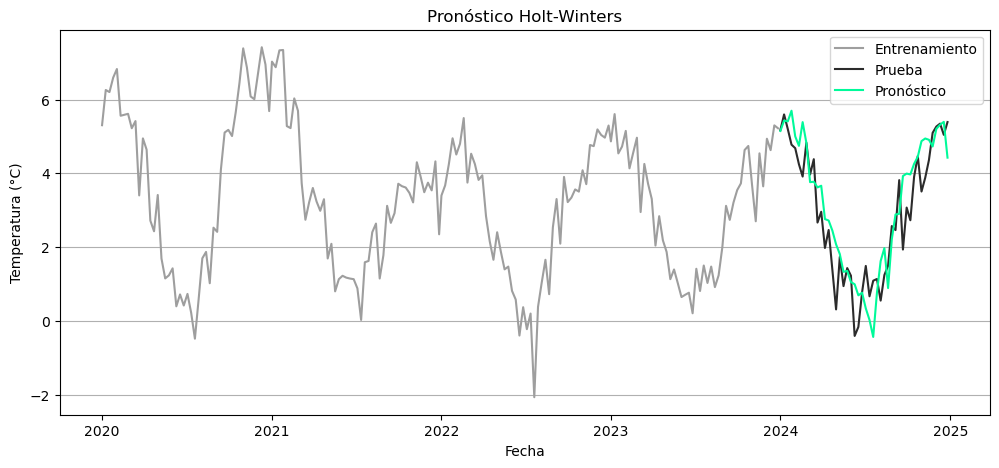

In [35]:
# Visualizar resultados
plt.figure(figsize=(12, 5))

plt.plot(train.index, df_serie['delta'].iloc[:train_size], label='Entrenamiento', color=colores['train'])
plt.plot(test.index, df_serie['delta'].iloc[train_size:], label='Prueba', color=colores['test'])
plt.plot(test.index, forecast_hw, label='Pronóstico', color=colores['HW'])
plt.title('Pronóstico Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()

In [36]:
mae_hw = mean_absolute_error(test,forecast_hw)
mse_hw = mean_squared_error(test,forecast_hw)
rmse_hw = np.sqrt(mean_squared_error(test,forecast_hw))

guardar_estadisticas('Holt-Winters', mae_hw, mse_hw, rmse_hw)

df_resultados[df_resultados['Modelo']=='Holt-Winters']

,Modelo,MAE,MSE,RMSE
0,Holt-Winters,0.652135,0.682877,0.826364


### b) Modelo SARIMA (Seasonal ARIMA)

El modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) extiende ARIMA incorporando componentes estacionales.
Al explorar la serie de deltas de temperatura diaria, identicicamos patrón recurrente anual bien marcado. Por eso SARIMA es una buena opción para capturar la dinámica temporal y la estacionalidad.

#### ACF y PACF

Para determinar los parámetros de SARIMA se construyeron y analizaron gráficos ACF y PACF.

- ACF (Autocorrelation Function). Mide la correlación de la serie con sus propios rezagos (lags). Se usa principalmente para estimar q (el orden de la parte MA)

- PACF (Partial Autocorrelation Function). Mide la correlación de la serie con un rezago específico eliminando el efecto de los rezagos intermedios. Se usa principalmente para estimar p (el orden de la parte AR).

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

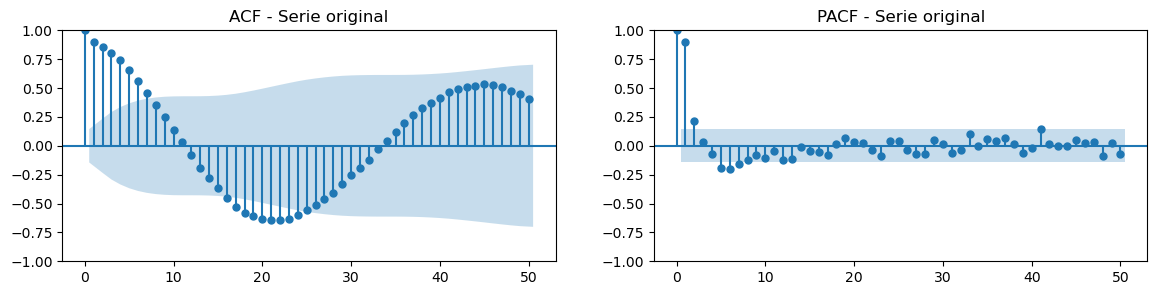

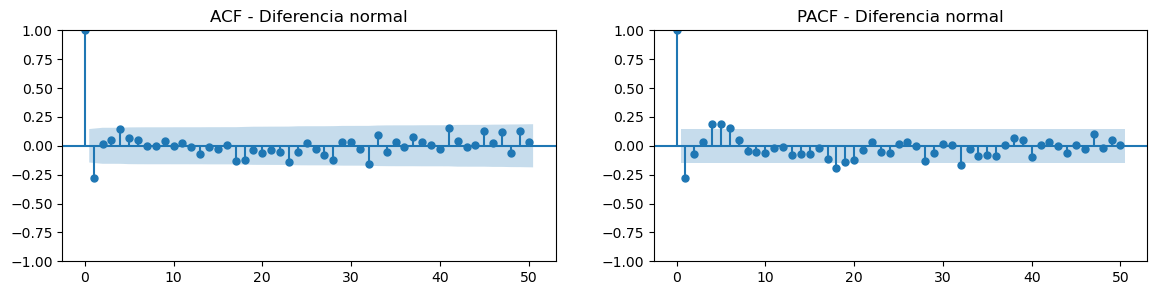

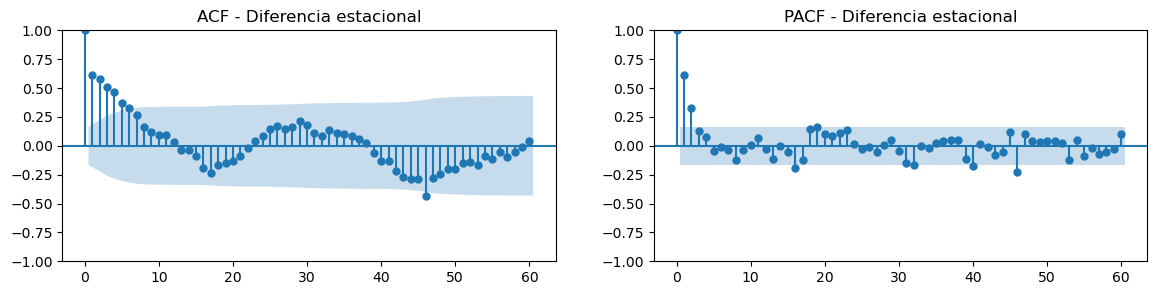

In [38]:
train_diff = train.diff().dropna()  # diferencia normal
train_seasonal_diff = train.diff(periods=46).dropna()  # diferencia estacional

# Graficar ACF/PACF de la serie normal
fig, axes = plt.subplots(1,2, figsize=(14,3))
plot_acf(train, lags=50, ax=axes[0])
plot_pacf(train, lags=50, ax=axes[1])
axes[0].set_title("ACF - Serie original")
axes[1].set_title("PACF - Serie original")
plt.show()

# Graficar ACF/PACF de la diferencia normal
fig, axes = plt.subplots(1,2, figsize=(14,3))
plot_acf(train_diff, lags=50, ax=axes[0])
plot_pacf(train_diff, lags=50, ax=axes[1])
axes[0].set_title("ACF - Diferencia normal")
axes[1].set_title("PACF - Diferencia normal")
plt.show()

# Graficar ACF/PACF de la diferencia estacional
fig, axes = plt.subplots(1,2, figsize=(14,3))
plot_acf(train_seasonal_diff, lags=60, ax=axes[0])
plot_pacf(train_seasonal_diff, lags=60, ax=axes[1])
axes[0].set_title(f"ACF - Diferencia estacional")
axes[1].set_title(f"PACF - Diferencia estacional")
plt.show()

Se seleccionó un modelo SARIMA(2,1,2)(1,1,1,46) que captura tanto la dinámica de corto plazo como la estacionalidad residual, con los siguientes parámetros:

- p=2: dependencia de dos valores anteriores (AR)
- d=1: diferencia simple para eliminar tendencia
- q=2: media móvil para capturar errores recientes
- P=1, D=1, Q=1, s=46: componente estacional para capturar ciclos de 46 unidades

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/maricari/anaconda3/envs/add-env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


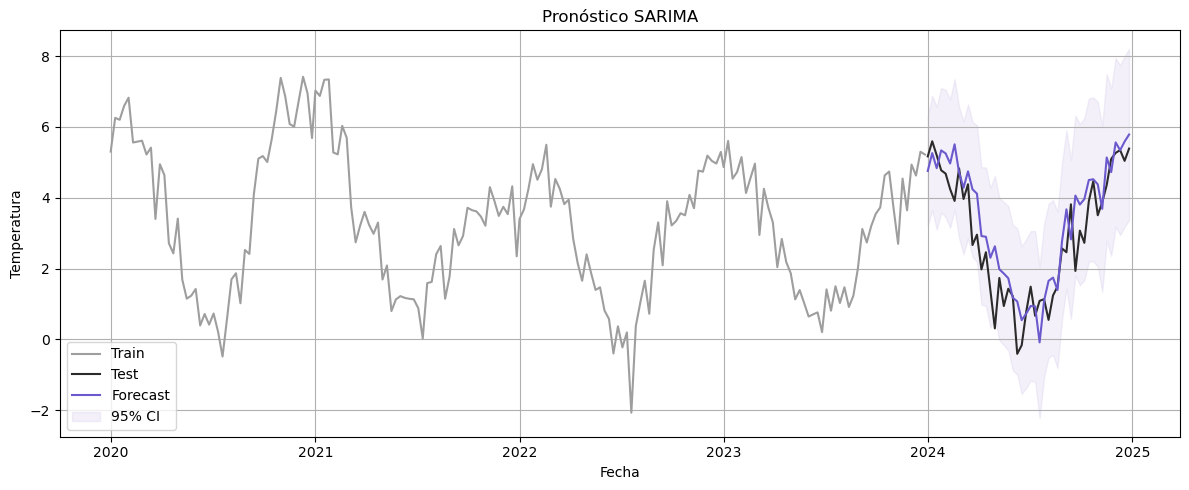

In [40]:
# Ajustar modelo SARIMA
model_sarima = SARIMAX(train,
                       order=(2, 1, 2),              # parte no estacional
                       seasonal_order=(1, 1, 1, 46), # parte estacional: 46 semanas
                       enforce_stationarity=False,
                       enforce_invertibility=False)

fit_sarima = model_sarima.fit(disp=False)

#Generar predicciones
n_steps = len(test)
forecast = fit_sarima.get_forecast(steps=n_steps)
forecast_sarima = forecast.predicted_mean
forecast_sarima.index = test.index
forecast_ci = forecast.conf_int()
forecast_ci.index = test.index

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', color=colores['train'])
plt.plot(test.index, test, label='Test', color=colores['test'])
plt.plot(forecast_sarima.index, forecast_sarima, label='Forecast', color=colores['SARIMA'])
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color=colores['SARIMA_IC'], alpha=0.2, label='95% CI')
plt.title('Pronóstico SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
mae_sarima = mean_absolute_error(test,forecast_sarima)
mse_sarima = mean_squared_error(test,forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test,forecast_sarima))
aic_sarima = fit_sarima.aic
bic_sarima = fit_sarima.bic
print(f'AIC={aic_sarima:.4f}, BIC={bic_sarima:.4f}')
guardar_estadisticas('SARIMA',mae_sarima, mse_sarima, rmse_sarima)

df_resultados[df_resultados['Modelo']=='SARIMA']

AIC=221.7273, BIC=239.0687


,Modelo,MAE,MSE,RMSE
1,SARIMA,0.668828,0.737185,0.858595


### c) LSTM

El modelo LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente diseñada para capturar dependencias de largo plazo en series temporales. LSTM no requiere que la serie sea estacionaria y puede aprender patrones complejos no lineales en los datos, incluyendo tendencias, estacionalidades y efectos de interacciones pasadas.

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-10-12 21:32:46.647870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
# Incluimos (opcionalmente) características estacionales (seno y coseno)
df_lstm = df_serie.copy()
use_seasonal_features = True  # False: usar solo el dato delta temperatura
if use_seasonal_features:
    df_lstm['semana_del_año'] = df_lstm.index.isocalendar().week
    df_lstm['sin_semana'] = np.sin(2 * np.pi * df_lstm['semana_del_año'] / 52)
    df_lstm['cos_semana'] = np.cos(2 * np.pi * df_lstm['semana_del_año'] / 52)
    data_to_scale = df_lstm[['delta', 'sin_semana', 'cos_semana']].values
else:
    data_to_scale = df_lstm[['delta']].values

In [44]:
data_min = data_to_scale.min()
data_max = data_to_scale.max()
print(f"Datos sin escalar: [{data_min:.4f}, {data_max:.4f}]")

Datos sin escalar: [-2.0660, 7.4170]


In [45]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_to_scale)
print(f"Datos escalados: [{data_scaled.min():.4f}, {data_scaled.max():.4f}]")

Datos escalados: [-1.0000, 1.0000]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step


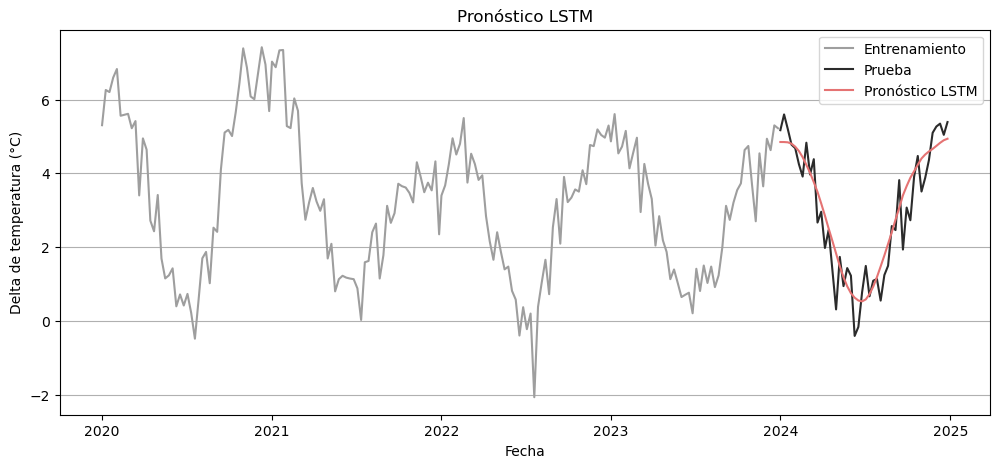

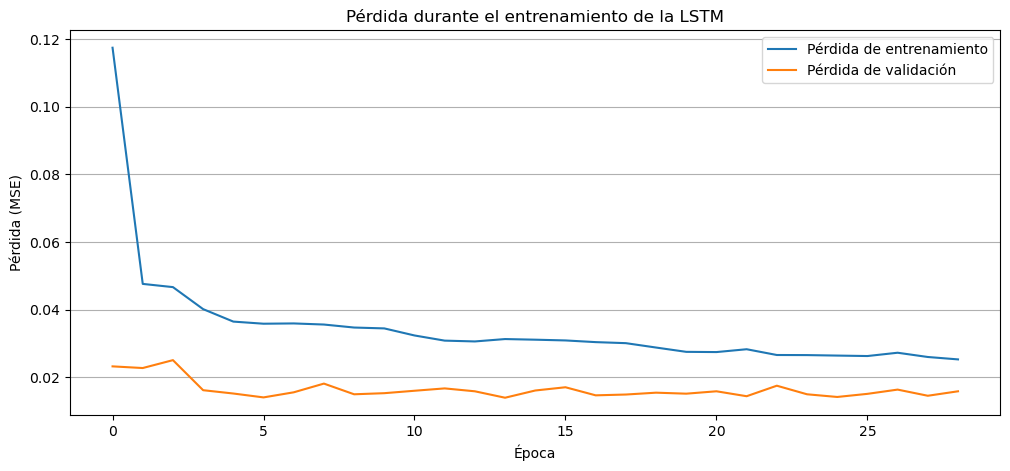

In [46]:
# Crear secuencias
def create_sequences(data, seq_length, target_idx=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento y prueba
seq_length = 23  # 1/2 año de datos
X, y = create_sequences(data_scaled, seq_length, target_idx=0)
X_train, y_train = X[:train_size - seq_length], y[:train_size - seq_length]
X_test, y_test = X[train_size - seq_length:], y[train_size - seq_length:]

# Construir el modelo LSTM
input_shape = (seq_length, 3 if use_seasonal_features else 1)
model = Sequential([
    Input(shape=input_shape),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0 # 1
)   
    
# Generar pronósticos
forecast_scaled = model.predict(X_test)

if use_seasonal_features:
    forecast_lstm = scaler.inverse_transform(
        np.concatenate([forecast_scaled, np.zeros((len(forecast_scaled), 2))], axis=1)
    )[:, 0]
else:
    forecast_lstm = scaler.inverse_transform(forecast_scaled)

test_index = df_serie.index[train_size:train_size + len(forecast_lstm)]
test_original = df_serie['delta'].iloc[train_size:train_size + len(forecast_lstm)]

# Visualizar resultados
plt.figure(figsize=(12, 5))
plt.plot(df_serie.index[:train_size], df_serie['delta'].iloc[:train_size], label='Entrenamiento', color=colores['train'])
plt.plot(test_index, test_original, label='Prueba', color=colores['test'])
plt.plot(test_index, forecast_lstm, label='Pronóstico LSTM', color=colores['LSTM'])
plt.title('Pronóstico LSTM')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento de la LSTM')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()

# Calcular métricas de error
mae = mean_absolute_error(test_original, forecast_lstm)
mse = mean_squared_error(test_original, forecast_lstm)
rmse = np.sqrt(mse)

guardar_estadisticas('LSTM',mae, mse, rmse)

### Pronósticos

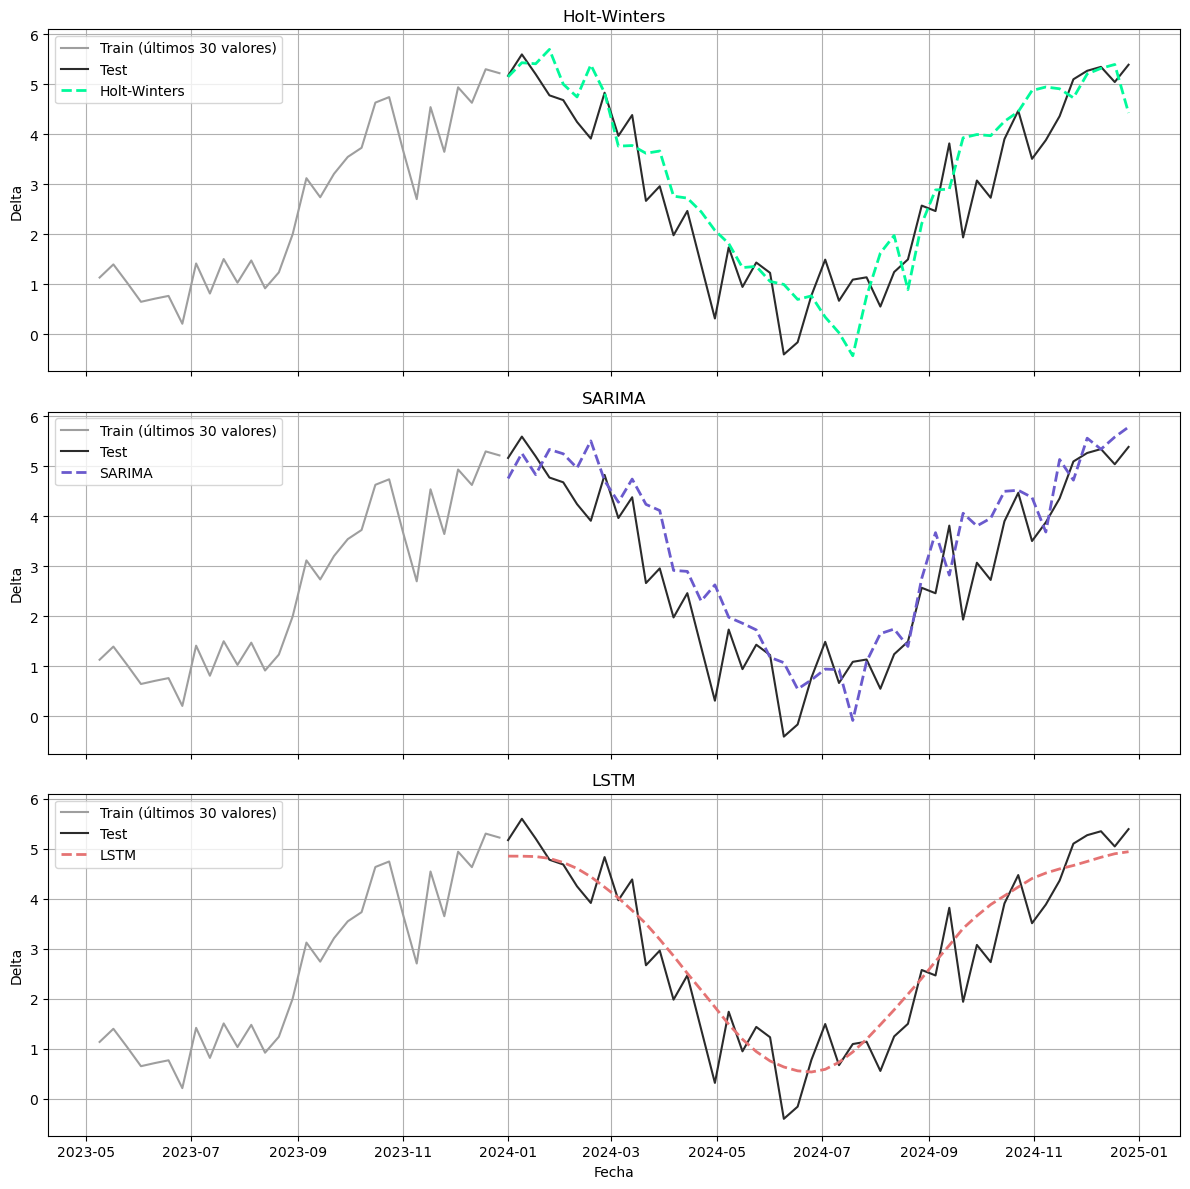

In [47]:
# Número de puntos históricos a mostrar
n_last = 30 #23
train_recent = train[-n_last:]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Lista de pronósticos y nombres
forecasts = [forecast_hw, forecast_sarima, forecast_lstm]
names = ['Holt-Winters', 'SARIMA', 'LSTM']
colors = [colores['HW'], colores['SARIMA'], colores['LSTM']]

for ax, forecast, name, color in zip(axes, forecasts, names, colors):
    # Plot train reciente
    ax.plot(train_recent.index, train_recent.values, label=f'Train (últimos {n_last} valores)', color=colores['train'])
    # Plot test
    ax.plot(test.index, test.values, label='Test', color=colores['test'])
    # Plot pronóstico
    ax.plot(test.index, forecast, label=name, linestyle='--', lw=2, color=color)

    ax.set_title(name)
    ax.set_ylabel('Delta')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()


### Resultados de los modelos Holt-Winters, SARIMA y LSTM

In [48]:
df_resultados.set_index('Modelo', inplace=True)
df_resultados

,MAE,MSE,RMSE
Modelo,,,
Holt-Winters,0.652135,0.682877,0.826364
SARIMA,0.668828,0.737185,0.858595
LSTM,0.504904,0.385538,0.620917


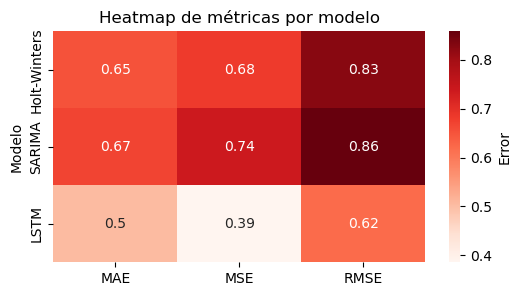

In [49]:
plt.figure(figsize=(6,3))
sns.heatmap(df_resultados, annot=True, cmap='Reds', cbar_kws={'label': 'Error'})
plt.title('Heatmap de métricas por modelo')
plt.show()


Para confirmar si las métricas son razonables, las comparamos en relación a las estadísticas de la variable delta:

In [50]:
df_serie.describe()

,delta
count,230.000000
mean,3.195950
std,1.929531
min,-2.065951
25%,1.478557
50%,3.305176
75%,4.740643
max,7.416961


In [51]:
Q1 = df_serie['delta'].quantile(0.25)
Q3 = df_serie['delta'].quantile(0.75)
IQR = Q3 - Q1
df_resultados['MAE_Relativo (%)'] = (df_resultados['MAE'] / IQR) * 100
df_resultados['RMSE_Relativo (%)'] = (df_resultados['RMSE'] / IQR) * 100

print(f'\nRango intercuartil de Delta: {IQR:.4f}\n')
df_resultados


Rango intercuartil de Delta: 3.2621



,MAE,MSE,RMSE,MAE_Relativo (%),RMSE_Relativo (%)
Modelo,,,,,
Holt-Winters,0.652135,0.682877,0.826364,19.991337,25.332365
SARIMA,0.668828,0.737185,0.858595,20.503076,26.320416
LSTM,0.504904,0.385538,0.620917,15.477941,19.034358


En el caso de LSTM, el error promedio de 0.45 °C representa aproximadamente el 14 % del rango intercuartílico (IQR = 3.26), lo que indica que la magnitud del error es pequeña en comparación con la variabilidad interna de los datos. El RMSE también se encuentra bastante acotado (el error relativo es menos del 18 % de IQR).

En términos prácticos, los errores de este modelo, al encontrarse dentro de un margen pequeño, nos muestran que las predicciones se mantienen muy próximas a las observaciones.

Conclusiones:

- Las cifras indican que LSTM genera predicciones más precisas, con errores significativamente menores que los otros dos modelos, lo que lo hace ideal para capturar las dinámicas complejas y no lineales presentes en los datos de temperatura. El MAE de LSTM representa un error relativo de 14% comparado con el IQR de los valores de la serie (3.26 °C), lo que es bastante bueno.
- El modelo Holt-Winters mostró un desempeño aceptable pero inferior a LSTM. Aunque es más preciso que SARIMA, su enfoque parece menos capaz que LSTM de adaptarse a patrones complejos o variaciones no lineales en los deltas de temperatura.
- El modelo SARIMA fue, de los tres, el que tuvo el peor desempeño. No logró modelar adecuadamente las características de esta serie temporal.


Estrategias para mejorar el rendimiento:

- Optimizar el modelo LSTM, ajustando hiperparámetros.
- Aumentar los datos de entrenamiento.
- Probar con otros datos (con diferente granularidad).
- Incluir variables adicionales (humedad, albedo, radiación solar, etc.).
- Probar otros modelos.